In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPool2D, BatchNormalization
from sklearn.preprocessing import OneHotEncoder

In [73]:
(f_tra, l_tra), (f_tes, l_tes) = keras.datasets.mnist.load_data()

In [74]:
img_width, img_height = f_tra.shape[1], f_tra.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

Text(0.5, 1.0, '9')

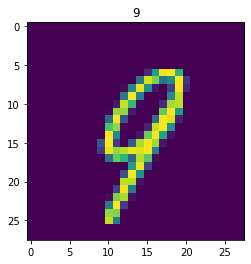

In [75]:
plt.imshow(f_tra[22])
plt.title(l_tra[22])

In [76]:
f_tra = (f_tra.astype('float32') / 255).reshape(f_tra.shape[0], img_height, img_width, num_channels)
f_tes = (f_tes.astype('float32') / 255).reshape(f_tes.shape[0], img_height, img_width, num_channels)

In [77]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [78]:
i      = Input(shape=(img_height, img_width, num_channels), name='encoder_input') #(28, 28, 1)

x      = Conv2D(filters=4, kernel_size=5, strides=1, activation='relu', name='layer1')(i) #(24, 24, 4)
# x      = BatchNormalization()(x)

x      = Conv2D(filters=8, kernel_size=5, strides=1, activation='relu')(x) #(20, 20, 8)
# x      = BatchNormalization()(x)

x      = Conv2D(filters=16, kernel_size=5, strides=1, activation='relu')(x) #(16, 16, 16)
# x      = BatchNormalization()(x)

x      = Flatten()(x) #(16*16*16, )
x      = Dense(16*16)(x) #(16*16, )
# x      = BatchNormalization()(x)

mu     = Dense(latent_dim, name='z_mu')(x) #(2, )
sigma  = Dense(latent_dim, name='z_log_sigma')(x) #(2, )
z      = Sampling()([mu, sigma])

encoder = keras.Model(i, [mu, sigma, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 24, 24, 4)    104         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 20, 20, 8)    808         layer1[0][0]                     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 16)   3216        conv2d_14[0][0]                  
____________________________________________________________________________________________

In [79]:
latent_i = keras.Input(shape=(latent_dim,))
x        = layers.Dense(16*16, activation="relu")(latent_i)
# x        = BatchNormalization()(x)

x        = layers.Dense(16*16*16, activation="relu")(x)
x        = layers.Reshape((16, 16, 16))(x)
# x        = BatchNormalization()(x)

x        = layers.Conv2DTranspose(8, 5, activation="relu", strides=1)(x)
# x        = BatchNormalization()(x)
x        = layers.Conv2DTranspose(4, 5, activation="relu", strides=1)(x)
# x        = BatchNormalization()(x)
o        = layers.Conv2DTranspose(1, 5, activation="sigmoid", strides=1)(x)

decoder = keras.Model(latent_i, o, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              1052672   
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 20, 20, 8)         3208      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 24, 24, 4)         804       
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         101 

In [80]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [81]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002))

In [82]:
F = np.concatenate([f_tra, f_tes], axis=0)
F.shape

(70000, 28, 28, 1)

In [83]:
def viz_latent_space(epoch, verbos=False):
    cmap = plt.cm.get_cmap('jet', 10)
    mu, _, _ = encoder.predict(f_tra)
    plt.figure(figsize=(8, 8))
    for l in np.unique(l_tra):
        mask = (l_tra == l)
        z1, z2 = mu[mask, 0], mu[mask, 1]
        plt.scatter(z1, z2, color = cmap(l), alpha=0.25, label = l, edgecolors='black')
    #   plt.scatter(mu[:, 0], mu[:, 1], c=l_tra, alpha=0.3, label=l_tra)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.legend()
    #   plt.colorbar()
    plt.grid()
    plt.title(f'latet space visualization: epoch {epoch}')

    x_l, x_u = min(mu[:, 0]), max(mu[:, 0])
    y_l, y_u = min(mu[:, 1]), max(mu[:, 1])

    filename1 = 'latent_%04d.png' % (epoch)
    plt.savefig(filename1)
    plt.show()
    return x_l, x_u, y_l, y_u

def plot_latent(epoch, verbos=False):
    # display a n*n 2D manifold of digits
    x_l, x_u, y_l, y_u = viz_latent_space(epoch, verbos)
    n = 20
    digit_size = 28
    figsize = 8
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_l, x_u, n)
    grid_y = np.linspace(y_l, y_u, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.title(f'image grid - epoch{epoch}')
    filename1 = 'grid_%04d.png' % (epoch)
    plt.savefig(filename1, bbox_inches='tight')
    plt.show()

In [84]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, period=40):
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
       if epoch % self.period == 0:
           plot_latent(epoch+1, True)

In [87]:
call_back = GANMonitor(10)
epochs = 50

Epoch 1/50
547/547 [==============================] - 4s 7ms/step - loss: 159.9293 - reconstruction_loss: 156.8219 - kl_loss: 3.1074


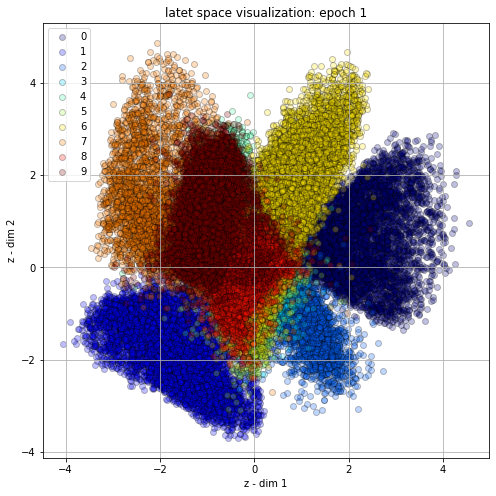

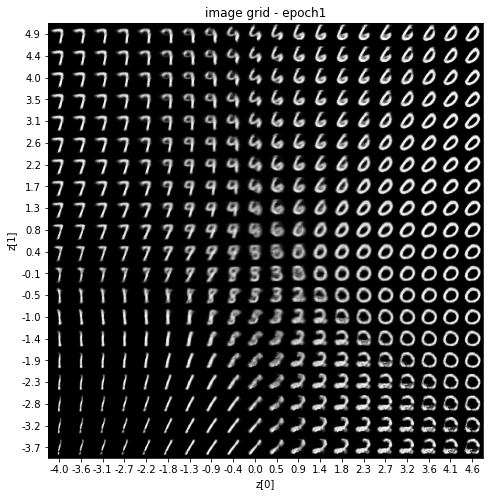

Epoch 2/50
547/547 [==============================] - 4s 8ms/step - loss: 154.9835 - reconstruction_loss: 151.6941 - kl_loss: 3.2894
Epoch 3/50
547/547 [==============================] - 4s 7ms/step - loss: 152.6508 - reconstruction_loss: 149.2666 - kl_loss: 3.3842
Epoch 4/50
547/547 [==============================] - 4s 7ms/step - loss: 150.8987 - reconstruction_loss: 147.4696 - kl_loss: 3.4291
Epoch 5/50
547/547 [==============================] - 4s 7ms/step - loss: 150.0152 - reconstruction_loss: 146.5493 - kl_loss: 3.4659
Epoch 6/50
547/547 [==============================] - 4s 7ms/step - loss: 149.5034 - reconstruction_loss: 146.0021 - kl_loss: 3.5013
Epoch 7/50
547/547 [==============================] - 4s 7ms/step - loss: 148.9068 - reconstruction_loss: 145.3755 - kl_loss: 3.5313
Epoch 8/50
547/547 [==============================] - 4s 7ms/step - loss: 148.4528 - reconstruction_loss: 144.8915 - kl_loss: 3.5613
Epoch 9/50
547/547 [==============================] - 4s 7ms/step - l

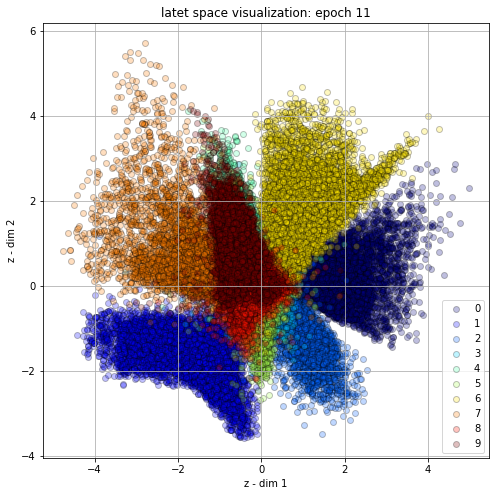

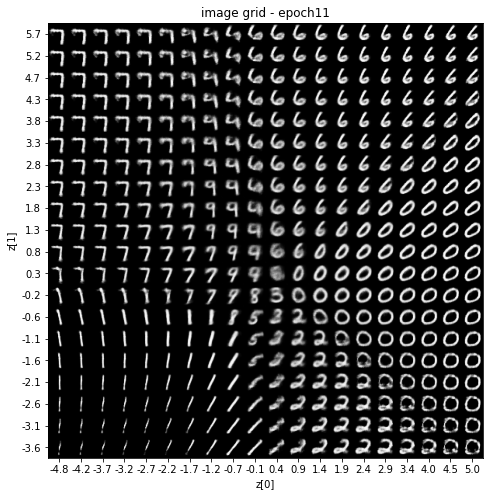

Epoch 12/50
547/547 [==============================] - 4s 8ms/step - loss: 147.2557 - reconstruction_loss: 143.6479 - kl_loss: 3.6078
Epoch 13/50
547/547 [==============================] - 4s 8ms/step - loss: 147.0657 - reconstruction_loss: 143.4410 - kl_loss: 3.6246
Epoch 14/50
547/547 [==============================] - 4s 8ms/step - loss: 146.8625 - reconstruction_loss: 143.2287 - kl_loss: 3.6338
Epoch 15/50
547/547 [==============================] - 4s 8ms/step - loss: 146.6537 - reconstruction_loss: 142.9999 - kl_loss: 3.6538
Epoch 16/50
547/547 [==============================] - 4s 8ms/step - loss: 146.5414 - reconstruction_loss: 142.8945 - kl_loss: 3.6469
Epoch 17/50
547/547 [==============================] - 4s 8ms/step - loss: 146.3369 - reconstruction_loss: 142.6628 - kl_loss: 3.6741
Epoch 18/50
547/547 [==============================] - 4s 7ms/step - loss: 146.1914 - reconstruction_loss: 142.5251 - kl_loss: 3.6663
Epoch 19/50
547/547 [==============================] - 4s 7ms/

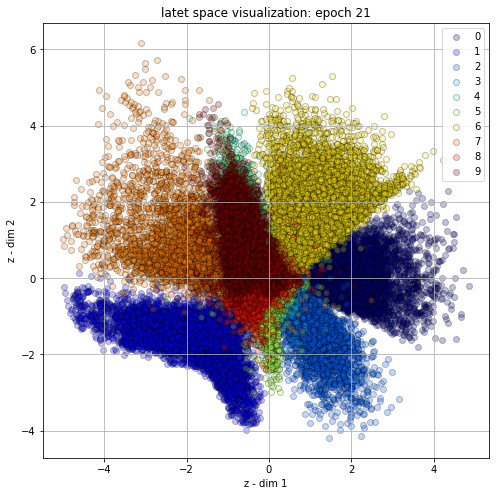

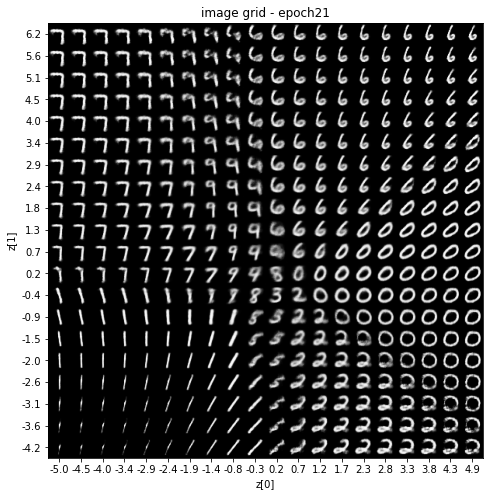

Epoch 22/50
547/547 [==============================] - 5s 9ms/step - loss: 145.6240 - reconstruction_loss: 141.9533 - kl_loss: 3.6707
Epoch 23/50
547/547 [==============================] - 5s 9ms/step - loss: 145.5667 - reconstruction_loss: 141.8740 - kl_loss: 3.6927
Epoch 24/50
547/547 [==============================] - 5s 9ms/step - loss: 145.5355 - reconstruction_loss: 141.8397 - kl_loss: 3.6958
Epoch 25/50
547/547 [==============================] - 5s 9ms/step - loss: 145.4840 - reconstruction_loss: 141.7903 - kl_loss: 3.6937
Epoch 26/50
547/547 [==============================] - 5s 9ms/step - loss: 145.2543 - reconstruction_loss: 141.5522 - kl_loss: 3.7021
Epoch 27/50
547/547 [==============================] - 5s 8ms/step - loss: 145.2159 - reconstruction_loss: 141.5084 - kl_loss: 3.7074
Epoch 28/50
547/547 [==============================] - 4s 8ms/step - loss: 145.1288 - reconstruction_loss: 141.4220 - kl_loss: 3.7068
Epoch 29/50
547/547 [==============================] - 4s 8ms/

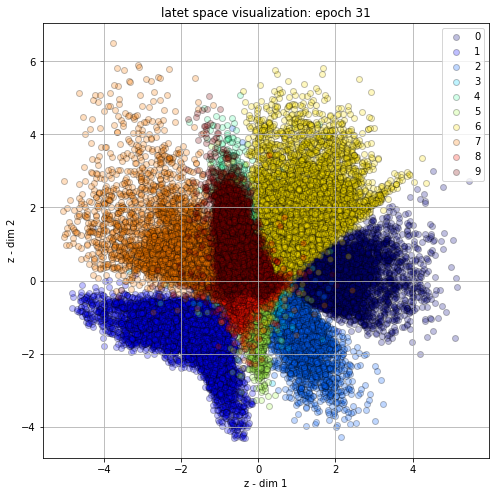

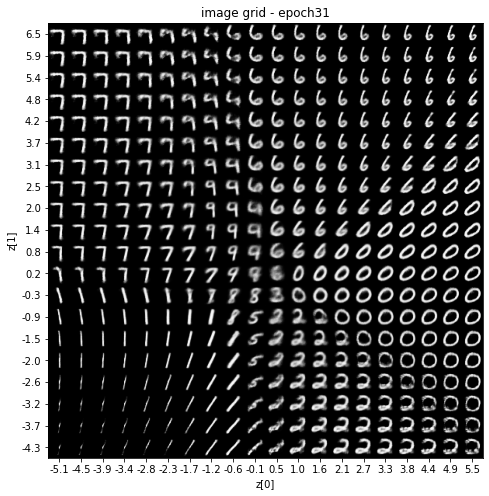

Epoch 32/50
547/547 [==============================] - 5s 9ms/step - loss: 144.8652 - reconstruction_loss: 141.1329 - kl_loss: 3.7323
Epoch 33/50
547/547 [==============================] - 5s 9ms/step - loss: 144.8210 - reconstruction_loss: 141.0897 - kl_loss: 3.7313
Epoch 34/50
547/547 [==============================] - 5s 10ms/step - loss: 144.8715 - reconstruction_loss: 141.1289 - kl_loss: 3.7426
Epoch 35/50
547/547 [==============================] - 5s 9ms/step - loss: 144.8172 - reconstruction_loss: 141.0769 - kl_loss: 3.7403
Epoch 36/50
547/547 [==============================] - 5s 9ms/step - loss: 144.5256 - reconstruction_loss: 140.7882 - kl_loss: 3.7374
Epoch 37/50
547/547 [==============================] - 5s 9ms/step - loss: 144.6426 - reconstruction_loss: 140.9183 - kl_loss: 3.7243
Epoch 38/50
547/547 [==============================] - 5s 9ms/step - loss: 144.4368 - reconstruction_loss: 140.6958 - kl_loss: 3.7410
Epoch 39/50
547/547 [==============================] - 5s 9ms

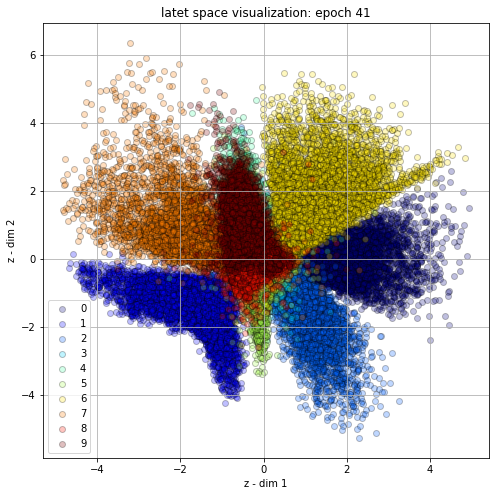

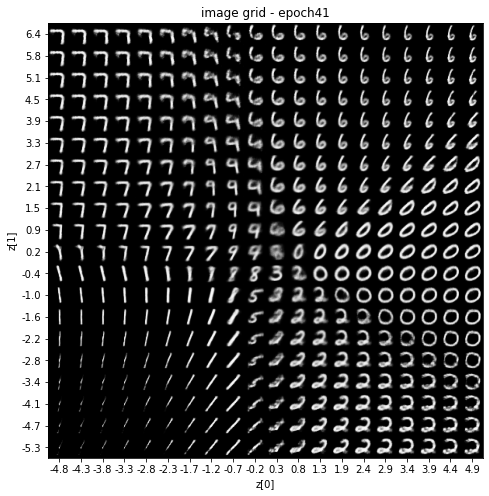

Epoch 42/50
547/547 [==============================] - 5s 9ms/step - loss: 144.2592 - reconstruction_loss: 140.5098 - kl_loss: 3.7494
Epoch 43/50
547/547 [==============================] - 5s 10ms/step - loss: 144.4301 - reconstruction_loss: 140.6770 - kl_loss: 3.7531
Epoch 44/50
547/547 [==============================] - 5s 10ms/step - loss: 144.2450 - reconstruction_loss: 140.4865 - kl_loss: 3.7586
Epoch 45/50
547/547 [==============================] - 5s 10ms/step - loss: 144.3103 - reconstruction_loss: 140.5459 - kl_loss: 3.7644
Epoch 46/50
547/547 [==============================] - 5s 10ms/step - loss: 144.2886 - reconstruction_loss: 140.5135 - kl_loss: 3.7751
Epoch 47/50
547/547 [==============================] - 5s 10ms/step - loss: 144.1423 - reconstruction_loss: 140.3766 - kl_loss: 3.7656
Epoch 48/50
547/547 [==============================] - 5s 9ms/step - loss: 144.1842 - reconstruction_loss: 140.4159 - kl_loss: 3.7683
Epoch 49/50
547/547 [==============================] - 5s

In [88]:
history = vae.fit(F, epochs=epochs, batch_size=128, callbacks = [call_back])

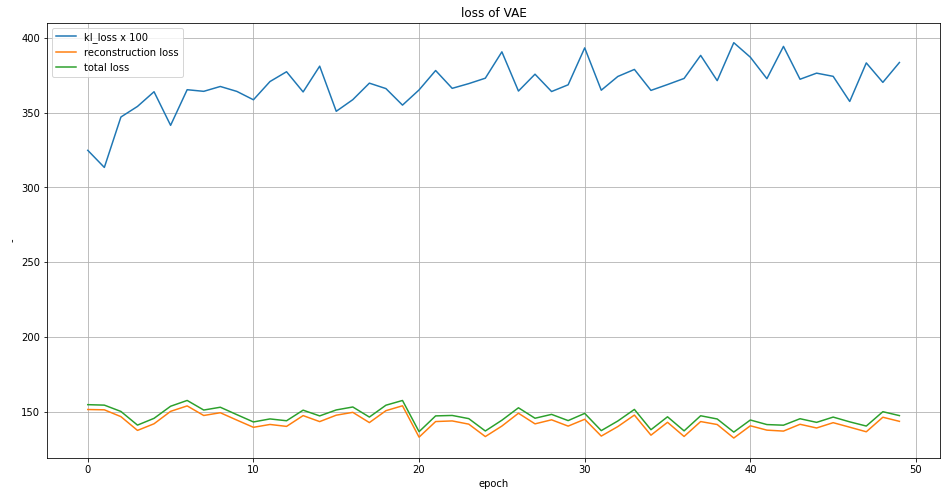

In [89]:
plt.figure(figsize=(16, 8))
plt.plot([100*i for i in history.history['kl_loss']], label='kl_loss x 100')
plt.plot(history.history['reconstruction_loss'], label='reconstruction loss')
plt.plot(history.history['loss'], label='total loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('-')
plt.title('loss of VAE')
plt.legend()
plt.show()

hbhbnbnb 


(70000, 28, 28, 1)

In [66]:
i      = Input(shape=(img_height+1, img_width, num_channels), name='encoder_input') #(28, 28, 1)
ii     = Input(shape=(10,1), name='label_input') #(28, 28, 1)
x      = Conv2D(filters=4, kernel_size=5, strides=1, activation='relu', name='layer1')(i) #(24, 24, 4)
# x      = BatchNormalization()(x)

x      = Conv2D(filters=8, kernel_size=5, strides=1, activation='relu')(x) #(20, 20, 8)
# x      = BatchNormalization()(x)

x      = Conv2D(filters=16, kernel_size=5, strides=1, activation='relu')(x) #(16, 16, 16)
# x      = BatchNormalization()(x)

x      = Flatten()(x) #(16*16*16, )
x      = Dense(16*16)(x) #(16*16, )
# x      = BatchNormalization()(x)

mu     = Dense(latent_dim, name='z_mu')(x) #(2, )
sigma  = Dense(latent_dim, name='z_log_sigma')(x) #(2, )
z      = Sampling()([mu, sigma])

c_encoder = keras.Model(i, [mu, sigma, z], name="c_encoder")
c_encoder.summary()

Model: "c_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 29, 28, 1)]  0                                            
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 25, 24, 4)    104         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 21, 20, 8)    808         layer1[0][0]                     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 17, 16, 16)   3216        conv2d_12[0][0]                  
__________________________________________________________________________________________

In [65]:
latent_i = keras.Input(shape=(latent_dim + 10,))
x        = layers.Dense(16*16, activation="relu")(latent_i)
# x        = BatchNormalization()(x)

x        = layers.Dense(16*16*16, activation="relu")(x)
x        = layers.Reshape((16, 16, 16))(x)
# x        = BatchNormalization()(x)

x        = layers.Conv2DTranspose(8, 5, activation="relu", strides=1)(x)
# x        = BatchNormalization()(x)
x        = layers.Conv2DTranspose(4, 5, activation="relu", strides=1)(x)
# x        = BatchNormalization()(x)
o        = layers.Conv2DTranspose(1, 5, activation="sigmoid", strides=1)(x)

c_decoder = keras.Model(latent_i, o, name="c_decoder")
c_decoder.summary()

Model: "c_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               3328      
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 20, 20, 8)         3208      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 24, 24, 4)         804       
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         10

In [69]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            a = np.concatenate([z, data[29]], axis=0)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vvbnm,.

In [70]:
cvae = CVAE(c_encoder, c_decoder)
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002))